In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score

# Setting the style for plots
plt.style.use("ggplot")

# Loading the datasets
df_confirmed = pd.read_csv("/content/CONVENIENT_global_confirmed_cases.csv")
df_deaths = pd.read_csv("/content/CONVENIENT_global_deaths.csv")

# Display the first few rows of the datasets
print("Confirmed Cases Data:")
print(df_confirmed.head())

print("\nDeaths Data:")
print(df_deaths.head())


Confirmed Cases Data:
   Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  Antarctica  \
0  Province/State          NaN      NaN      NaN      NaN     NaN         NaN   
1         1/23/20          0.0      0.0      0.0      0.0     0.0         0.0   
2         1/24/20          0.0      0.0      0.0      0.0     0.0         0.0   
3         1/25/20          0.0      0.0      0.0      0.0     0.0         0.0   
4         1/26/20          0.0      0.0      0.0      0.0     0.0         0.0   

   Antigua and Barbuda  Argentina  Armenia  ... Uruguay Uzbekistan Vanuatu  \
0                  NaN        NaN      NaN  ...     NaN        NaN     NaN   
1                  0.0        0.0      0.0  ...     0.0        0.0     0.0   
2                  0.0        0.0      0.0  ...     0.0        0.0     0.0   
3                  0.0        0.0      0.0  ...     0.0        0.0     0.0   
4                  0.0        0.0      0.0  ...     0.0        0.0     0.0   

  Venezuela Vietnam We

In [ ]:
world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df_confirmed.iloc[:,1:].columns
cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df_confirmed[i][1:]).sum())
world["Cases"]=cases

country_list=list(world["Country"].values)
idx = 0
for i in country_list:
    sayac = 0
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i
        elif j=="(":
            i = i[:sayac-1]
            country_list[idx]=i
        else:
            sayac += 1
    idx += 1
world["Country"]=country_list
world = world.groupby("Country")["Cases"].sum().reset_index()
world.head()
continent=pd.read_csv("/content/continents2.csv")
continent["name"]=continent["name"].str.upper()


In [ ]:
world["Cases Range"]=pd.cut(world["Cases"],[-150000,50000,200000,800000,1500000,15000000],labels=["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])
alpha =[]
for i in world["Country"].str.upper().values:
    if i == "BRUNEI":
        i="BRUNEI DARUSSALAM"
    elif  i=="US":
        i="UNITED STATES"
    if len(continent[continent["name"]==i]["alpha-3"].values)==0:
        alpha.append(np.nan)
    else:
        alpha.append(continent[continent["name"]==i]["alpha-3"].values[0])
world["Alpha3"]=alpha

fig = px.choropleth(world.dropna(),
                   locations="Alpha3",
                   color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["white","khaki","yellow","orange","red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1971: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


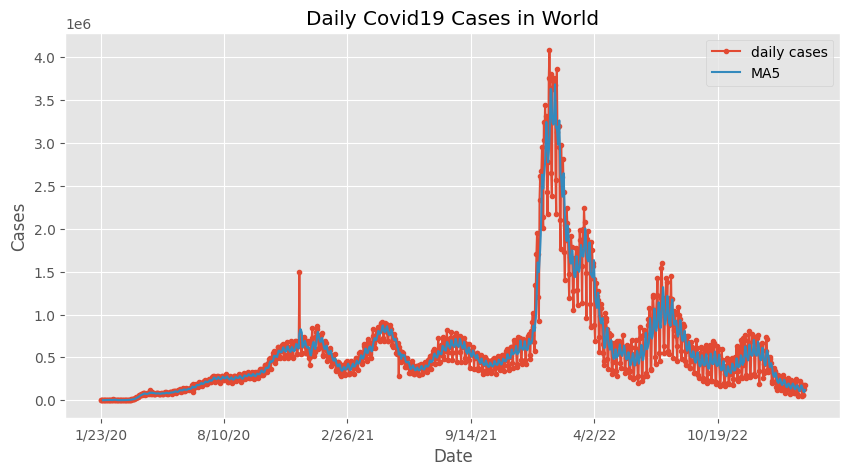

In [ ]:
count = []
for i in range(1,len(df_confirmed)):
    count.append(sum(pd.to_numeric(df_confirmed.iloc[i,1:].values)))

df = pd.DataFrame()
df["Date"] = df_confirmed["Country/Region"][1:]
df["Cases"] = count
df=df.set_index("Date")

count = []
for i in range(1,len(df_deaths)):
    count.append(sum(pd.to_numeric(df_deaths.iloc[i,1:].values)))

df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(10,5),label="daily cases")
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()

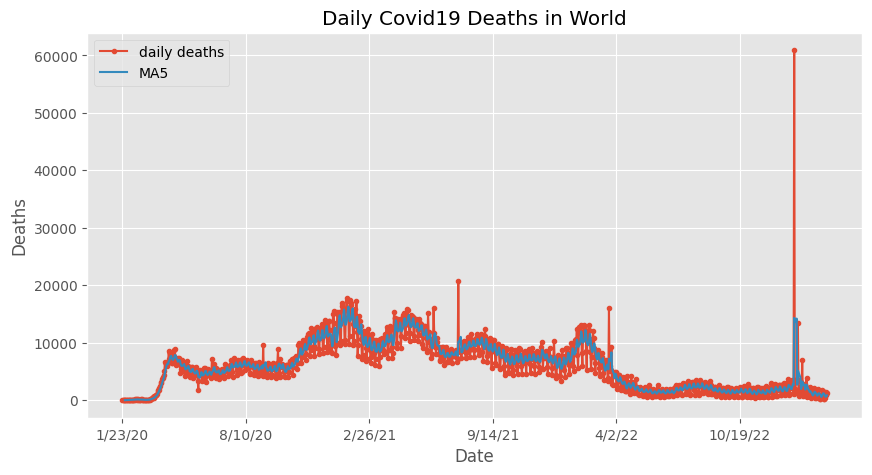

In [ ]:
df.Deaths.plot(title="Daily Covid19 Deaths in World",marker=".",figsize=(10,5),label="daily deaths")
df.Deaths.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()

<ipython-input-19-836ccd968556>:22: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxkz9vjp/hfborqci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxkz9vjp/g1mdwkzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97755', 'data', 'file=/tmp/tmpqxkz9vjp/hfborqci.json', 'init=/tmp/tmpqxkz9vjp/g1mdwkzu.json', 'output', 'file=/tmp/tmpqxkz9vjp/prophet_modelr5lnqsf1/prophet_model-20240811161115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


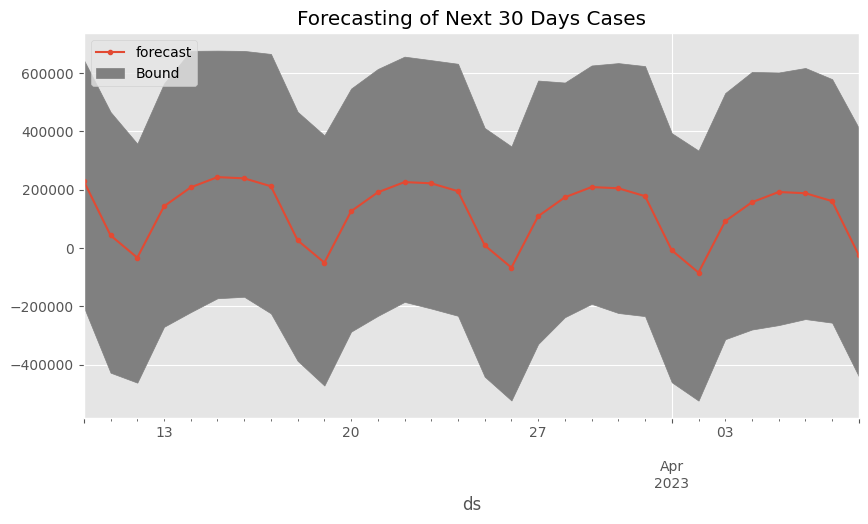

In [ ]:
class Fbprophet(object):
    def fit(self,data):

        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)

    def forecast(self,periods,freq):

        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)

    def plot(self,xlabel="Years",ylabel="Values"):

        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))

    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])

df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()